# SEN122A Statistical Analysis of Choice Behaviour 

## `Lab session 03B:`
## `Combining machine learning and discrete choice models`

**Delft University of Technology**<br>
**Q2 2025**<br>
**Instructor:** Sander van Cranenburgh<br>
**TA:**  Gabriel Nova <br>

### `Instructions`

**Lab sessions aim to:**<br>
* Show and reinforce how models and ideas presented in class are put to practice.<br>
* Help you gather hands-on machine learning skills.<br>

**Lab sessions are:**<br>
* Learning environments where you work with Jupyter notebooks and where you can get support from TAs and fellow students.<br> 
* Not graded and do not have to be submitted. 

### `Application: Modelling neighbourhood choices`

In this lab session, we will use neighbourhood location choice data of lab session 1: Stated Choice (SC) data, which was collected between 2017 and 2018 in four European cities: Hanover, Mainz, Bern, and Zurich. During this lab session, you will train a neural network and a hybrid choices model to uncover people's preferences over residential location choice attributes, such as the distance to the city centre and the share of foreigners in their neighbourhood. 

![sc](assets/sc_experiment.png)


This time the emphesize is on the balance that the researcher must strike between behavioural rigour and model fit.
To do so, in this lab session you will (1) develop a multilayer perceptron model and (2) build a hybrid choice models.

**`Learning objectives lab session 03`**

After completing the following lab session you will be able to:
* Train a hybrid choice model, using PyTorch
* Strike a balance between behavioural rigour and model fit
* Reflect on the strength and weaknesses of both data and theory-driven modelling approaches


**`This lab consists of 1 part and has 2 exercises`**

**Part 1**: The L-MNL model
- Excerise 1: "Features in MLP of L-MNL model"
- Excerise 2: "Forecasting using L-MNL model"

#### `Import packages`

In [1]:
# Biogeme
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import models
from biogeme.expressions import Beta, Variable, log

# Import required Python packages and modules
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Scikit-learn
from sklearn.preprocessing import StandardScaler

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Pandas setting to show all columns when displaying a pandas dataframe
pd.set_option('display.max_columns', None)

In [2]:
# Fix the seed numbers for reproducibility
np.random.seed(123)
torch.manual_seed(123)

In [3]:
# Add the utils folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

# Import custom functions
from utils.train_functions import show_loss_plot, print_model_summary, evaluate_lmnl

## Part 1: The L-MNL model

### `1. Load the data set prepared in Lab 03` <br>

In [4]:
# Create that path to the data file
data_path = Path(f'data/choice_data_cleaned_lab3B.dat')

# Load mode choice data into a pandas DataFrame
df = pd.read_csv(data_path, sep='\t')

# Define the relevant features of the alternatives
features_alt =   ['STORES1', 'TRANSPORT1', 'CITY1', 'NOISE1', 'GREEN1', 'FOREIGN1', 
                  'STORES2', 'TRANSPORT2', 'CITY2', 'NOISE2', 'GREEN2', 'FOREIGN2',
                  'STORES3', 'TRANSPORT3', 'CITY3', 'NOISE3', 'GREEN3', 'FOREIGN3']

# Define the relevant socio-economic variables
features_socio = ['AGE_2','AGE_3','WOMAN_1','HOMEOWNER_1','CAROWNER_1','RESPCITY_2','RESPCITY_3','RESPCITY_4','JOB_1','NONWESTERN_1','WESTERN_1']

# Show the first few rows of the dataframe
df.head()

,ID,CHOICE,STORES1,TRANSPORT1,CITY1,NOISE1,GREEN1,FOREIGN1,STORES2,TRANSPORT2,CITY2,NOISE2,GREEN2,FOREIGN2,STORES3,TRANSPORT3,CITY3,NOISE3,GREEN3,FOREIGN3,AGE_2,AGE_3,WOMAN_1,HOMEOWNER_1,CAROWNER_1,RESPCITY_2,RESPCITY_3,RESPCITY_4,JOB_1,NONWESTERN_1,WESTERN_1,draw,train_set,test_set
0,2,1,10,5,1,2,2,0.4,15,10,2,3,3,0.1,2,15,4,4,4,0.2,1,0,0,0,0,0,1,0,0,0,0,0.696469,True,False
1,2,2,15,5,4,4,1,0.1,2,10,5,1,2,0.2,5,15,1,2,3,0.3,1,0,0,0,0,0,1,0,0,0,0,0.696469,True,False
2,2,3,10,15,1,3,1,0.4,15,2,2,4,2,0.1,2,5,4,1,3,0.2,1,0,0,0,0,0,1,0,0,0,0,0.696469,True,False
3,2,2,15,15,5,4,4,0.4,2,2,1,1,1,0.1,5,5,2,2,2,0.2,1,0,0,0,0,0,1,0,0,0,0,0.696469,True,False
4,3,2,15,5,5,1,3,0.4,2,10,1,2,4,0.1,5,15,2,3,1,0.2,1,0,1,0,1,1,0,0,1,0,0,0.286139,True,False


In [5]:
# Reconstruct the test and training sets
df_train = df.loc[df['train_set'] == True,:].copy()
df_test  = df.loc[df['test_set'] == True,:].copy()

# Number of observations in the training and test sets
num_obs_train = len(df_train)
num_obs_test  = len(df_test)

print(f'Number of individuals in the df_train and df_test: \t{df_train.ID.nunique()}  {df_test.ID.nunique()} ')
print(f'Number of observations in the df_train and df_test: \t{len(df_train)} {len(df_test)} ')

Number of individuals in the df_train and df_test: 	1780  468 
Number of observations in the df_train and df_test: 	7120 1872 


To efficiently train MLPs it strongly recommended to scale (a.k.a. normalise) the features. We use sk-learn's 'StandardScaler'. 

In [6]:
# Initialize the scaler object
scaler = StandardScaler()

# Fit the scaler to the training data
scaler = scaler.fit(df_train[features_alt + features_socio])

# Apply the fitted scaler to the train and test sets
x_train_scaled = scaler.transform(df_train[features_alt + features_socio])
x_test_scaled =  scaler.transform(df_test [features_alt + features_socio])
    
# Create dataframes with the scaled data
df_train_scaled = pd.DataFrame(x_train_scaled, columns=[features_alt + features_socio])
df_test_scaled  = pd.DataFrame(x_test_scaled, columns=[features_alt + features_socio])

print('Shape of x_train', df_train_scaled.shape)
print('Shape of x_test', df_test_scaled.shape)

# Create the target values
# Y must be a dummy coded array
y_train_dummy = pd.get_dummies(df_train['CHOICE']).values.astype(int)
y_test_dummy = pd.get_dummies(df_test['CHOICE']).values.astype(int)

Shape of x_train (7120, 29)
Shape of x_test (1872, 29)


### `The L-MNL model `

Next, we will build and train a hybrid model, namely the L-MNL model. This model combines an interpretable part following the assumptions of the MNL model and a neural network that processes the rest of the variables that we do not want to interpret. More specifically, we want the **flexibility** of the MLP but still want to get out an **estimate of the willingness to pay to reduce the walking distance to the grocery stores, expressed in terms of distance to the public transport**.

The figure below conceptually shows this model:<br>

<p align="center">
<img width="600" src="assets/hybrid_model.png">
</p>

`i. Define the L-MNL model`<br>
To create the L-MNL model,we create a new class using PyTorch's nn.Module. <br>
* The MNL part is implemented with separate linear layers for features (transport and foreign), allowing the utility to be calculated for each alternative. <br>
* The MLP part consists of two hidden layers (linear1 and linear2) with a given number of neurons.<br>
* The forward function takes `x_mnl` and `x_mlp` as inputs. x_mlp is passed through the network layers, while applying activation functions. It outputs the utilities of each alternative `V_MLP`. x_mnl is used to compute utilities in a linear-additive fashion. 
* Finally, the utilities of boths parts are summed.

In [7]:
class LMNL(nn.Module):
    def __init__(self, input_size_mlp, hidden_size1, hidden_size2,output_size):
        super(LMNL,self).__init__()

        # Create betas for the MNL part
        self.B_transport = nn.Linear(1, 1, bias=False )
        self.B_stores   = nn.Linear(1, 1, bias=False )
                                 
        # Create the hidden layers for the MLP part
        self.linear1 = nn.Linear(input_size_mlp, hidden_size1, bias=False)
        self.linear2 = nn.Linear(hidden_size1,   hidden_size2, bias=False) 
        self.linear3 = nn.Linear(hidden_size2,   output_size,  bias=False) 

    def forward(self, X_MNL, X_MLP):
        
        # Utility functions for the MNL part 
        V_A = self.B_transport(X_MNL[:,0].unsqueeze(1))  + self.B_stores(X_MNL[:,1].unsqueeze(1))
        V_B = self.B_transport(X_MNL[:,2].unsqueeze(1))  + self.B_stores(X_MNL[:,3].unsqueeze(1))
        V_C = self.B_transport(X_MNL[:,4].unsqueeze(1))  + self.B_stores(X_MNL[:,5].unsqueeze(1))
                     
        # Concatenating tensors to maintain the output dimension
        V_MNL = torch.cat((V_A, V_B, V_C), dim=1)

        # The MLP part
        X_MLP = torch.tanh(self.linear1(X_MLP)) # tanh activation function for the 1st layer
        X_MLP = torch.tanh(self.linear2(X_MLP)) # tanh activation function for the 2nd layer
        V_MLP = self.linear3(X_MLP)             # linear activation function for the output layer

        # Sum the utilities from the MNL and MLP parts
        V = V_MNL + V_MLP
        return V

`ii. Prepare the data for training the L-MNL model`<br>
We need to split the features going into the MLP and MNL parts. Because we want to compute the WTP of stores over transport. Therefore, the features related to transport and stores go into the MNL part, while the other features, including socio-demographics, go into the MLP part. **Importantly**, the MNL features must NOT be scaled.<br><br>
Here we use `RESPCITY` as socio-demographic variable that enters the MLP.<br> 
Recall 'RESPCITY_1', 'RESPCITY_2', 'RESPCITY_3', 'RESPCITY_4' are dummy coded features,<br> where _1 = Mainz (the reference class), _2 = Hanover, _3 = Bern, _4 = Zurich.

In [8]:
# Create dataframe with features for MNL part
features_mnl = ['TRANSPORT1', 'STORES1','TRANSPORT2', 'STORES2','TRANSPORT3', 'STORES3']
x_mnl_train = df_train[features_mnl].values
x_mnl_test  = df_test[features_mnl].values

print('Shape of x_mnl_train\t', x_mnl_train.shape)
print('Shape of x_mnl_test\t', x_mnl_test.shape)

# Create dataframe with features for MLP part
features_mlp_alt = ['FOREIGN1', 'CITY1', 'NOISE1', 'GREEN1', 
                    'FOREIGN2', 'CITY2', 'NOISE2', 'GREEN2', 
                    'FOREIGN3', 'CITY3', 'NOISE3', 'GREEN3']


# Add socio-economic variables to the MLP part
x_mlp_train = df_train_scaled[features_mlp_alt + features_socio].values
x_mlp_test  = df_test_scaled[features_mlp_alt + features_socio].values

print('\nShape of x_mlp_train\t', x_mlp_train.shape)
print('Shape of x_mlp_test\t', x_mlp_test.shape)

Shape of x_mnl_train	 (7120, 6)
Shape of x_mnl_test	 (1872, 6)

Shape of x_mlp_train	 (7120, 23)
Shape of x_mlp_test	 (1872, 23)


Convert numpy data to PyTorch tensors

In [9]:
# Train set
x_mnl_train_tensor   = torch.tensor(x_mnl_train, dtype=torch.float)
x_mlp_train_tensor   = torch.tensor(x_mlp_train, dtype=torch.float)
y_train_dummy_tensor = torch.tensor(y_train_dummy, dtype=torch.float)

# Test set
x_mnl_test_tensor   = torch.tensor(x_mnl_test, dtype=torch.float)
x_mlp_test_tensor   = torch.tensor(x_mlp_test, dtype=torch.float)
y_test_dummy_tensor = torch.tensor(y_test_dummy, dtype=torch.float)

print('Size of the X_mnl_train tensor = ', x_mnl_train_tensor.size())
print('Size of the X_mlp_train tensor = ', x_mlp_train_tensor.size())
print('\nSize of the X_mnl_test tensor  = ', x_mnl_test_tensor.size())
print('Size of the X_mlp_test tensor  = ', x_mlp_test_tensor.size())

Size of the X_mnl_train tensor =  torch.Size([7120, 6])
Size of the X_mlp_train tensor =  torch.Size([7120, 23])

Size of the X_mnl_test tensor  =  torch.Size([1872, 6])
Size of the X_mlp_test tensor  =  torch.Size([1872, 23])


Create PyTorch DataLoaders

In [10]:
# Create a DataLoader for the train set
dataset_train_lmnl = TensorDataset(x_mnl_train_tensor, x_mlp_train_tensor, y_train_dummy_tensor)
train_loader_lmnl = DataLoader(dataset_train_lmnl, batch_size=250, shuffle=True)

# Create a DataLoader for the test set
dataset_test_lmnl = TensorDataset(x_mnl_test_tensor, x_mlp_test_tensor, y_test_dummy_tensor)
test_loader_lmnl = DataLoader(dataset_test_lmnl, batch_size=len(x_mnl_test_tensor), shuffle=False)

`iv. Create the L-MNL model object`<br>

In [11]:
# Define the dimensions
input_size_mnl = x_mnl_train_tensor.size()[1]  # Number of input features
input_size_mlp = x_mlp_train_tensor.size()[1]  # Number of input features
hidden_size1 = 10  # Number of units in first hidden layer
hidden_size2 = 10  # Number of units in second hidden layer
output_size = 3    # Number of output classes
print(f' input_size_mnl = {input_size_mnl}, input_size_mlp = {input_size_mlp}, hidden_size1 = {hidden_size1}, hidden_size2 = {hidden_size2}, output_size = {output_size}')

 input_size_mnl = 6, input_size_mlp = 23, hidden_size1 = 10, hidden_size2 = 10, output_size = 3


In [12]:
# Invoke the L-MNL model
model = LMNL(input_size_mlp, hidden_size1, hidden_size2, output_size)

# Print the model architecture
print_model_summary(model)

=== Model Summary ===
Layer: B_transport.weight  |	 Weights: 1
Layer: B_stores.weight     |	 Weights: 1
Layer: linear1.weight      |	 Weights: 230
Layer: linear2.weight      |	 Weights: 100
Layer: linear3.weight      |	 Weights: 30

Total trainable Weights: 362

=== Layers ===
Linear(in_features=1, out_features=1, bias=False)
Linear(in_features=1, out_features=1, bias=False)
Linear(in_features=23, out_features=10, bias=False)
Linear(in_features=10, out_features=10, bias=False)
Linear(in_features=10, out_features=3, bias=False)


`v. Define settings for the training`<br>

In [13]:
# Define training settings
nEpoch = 1000  # Set the number of epochs
lr = 0.0001  # Set the learning rate
status = 10  # Print status every 'status' epochs
patience = 5  # Number of epochs to wait before early stopping

`vi. Train the L-MNL model`<br>
Finally, we are ready to train the L-MNL model!

Epoch [    1/1000], Train Loss: 13066.457, Test Loss: 3298.085
Epoch [   10/1000], Train Loss: 12105.326, Test Loss: 3063.656
Epoch [   20/1000], Train Loss: 10922.828, Test Loss: 2770.934
Epoch [   30/1000], Train Loss: 9714.061, Test Loss: 2468.899
Epoch [   40/1000], Train Loss: 8736.863, Test Loss: 2224.072
Epoch [   50/1000], Train Loss: 8039.782, Test Loss: 2050.290
Epoch [   60/1000], Train Loss: 7522.738, Test Loss: 1922.638
Epoch [   70/1000], Train Loss: 7114.994, Test Loss: 1822.758
Epoch [   80/1000], Train Loss: 6792.764, Test Loss: 1745.068
Epoch [   90/1000], Train Loss: 6547.853, Test Loss: 1686.030
Epoch [  100/1000], Train Loss: 6368.634, Test Loss: 1644.630
Epoch [  110/1000], Train Loss: 6238.342, Test Loss: 1615.354
Epoch [  120/1000], Train Loss: 6142.695, Test Loss: 1595.166
Epoch [  130/1000], Train Loss: 6072.377, Test Loss: 1581.452
Epoch [  140/1000], Train Loss: 6020.637, Test Loss: 1571.921
Epoch [  150/1000], Train Loss: 5983.579, Test Loss: 1565.923
Epoch

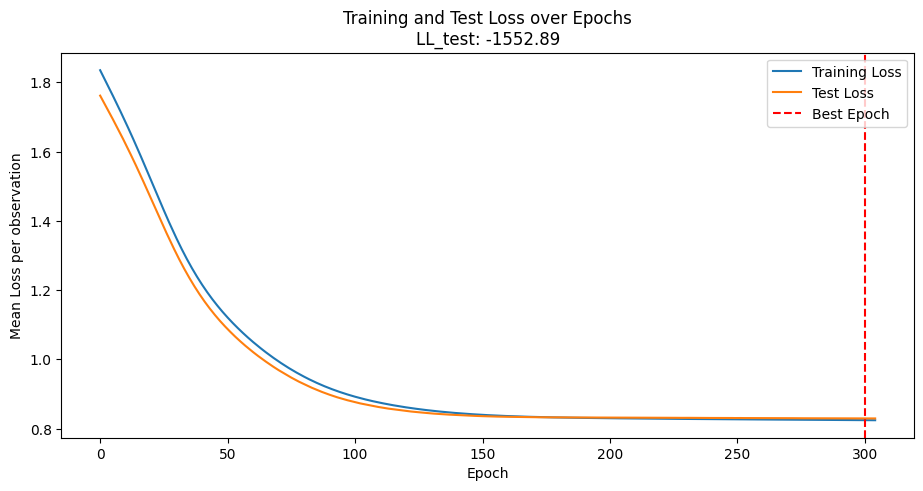

In [14]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(params=model.parameters(), lr=lr,  betas=(0.9, 0.999), eps=1e-07, weight_decay=0)

# Define lists to store losses
train_losses = []
test_losses = []

# Initialize early stopping counter 
counter = 0
best_loss = np.inf  # Set initial loss to infinity

# Training loop
for epoch in range(nEpoch):
    running_loss = 0.0
    for x_mnl, x_mlp, labels in train_loader_lmnl:
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(x_mnl,x_mlp)   

        # Compute the loss
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() # Log-likelihood on the training set

    # Evaluate on the test set
    test_loss = evaluate_lmnl(model, loss_fn, test_loader_lmnl)

    # Print status every 'status' epochs or epoch 0
    if epoch == 0 or (epoch + 1) % status == 0:
        print(f'Epoch [{epoch+1:5.0f}/{nEpoch}], Train Loss: {running_loss:0.3f}, Test Loss: {test_loss:0.3f}')

    # Store losses
    train_losses.append(running_loss)
    test_losses.append(test_loss)

    # Implement early stopping
    if test_loss < best_loss:
        best_loss = test_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            epoch_best = epoch + 1 - patience
            print(f'Early stopping. Best test loss found at epoch {epoch_best}')
            break
        
print('Training finished.')
print(f'LL_test_MLP: {-best_loss:0.2f}') # Take negative because loss is -LL
show_loss_plot(train_losses, test_losses,num_obs_train, num_obs_test, epoch_best)

In [15]:
# Compute the Willingness to pay to reduce the distance to the grovery store by one minute
LL_LMNL = best_loss
B_transport_LMNL = model.B_transport.weight.data.item()
B_stores_LMNL = model.B_stores.weight.data.item()
print(f'Beta_transport = {B_transport_LMNL:.4f}\nBeta_stores    = {B_stores_LMNL:.4f}')

WTP_LMNL = B_stores_LMNL/B_transport_LMNL
print(f'\nWillingness to pay to reduce one minute of walking time to the grocery store is: {WTP_LMNL:.2f} walking minutes to the public transport')

Beta_transport = -0.0866
Beta_stores    = -0.0468

Willingness to pay to reduce one minute of walking time to the grocery store is: 0.54 walking minutes to the public transport


`Reflections`
1. The L-MNL model attains a model fit on the test set (LL_test =~ -1,553) that is reasonably close to the fully flexible MLP model (which attained a LL_test of ~ -1,550). This means that the L-MNL model captures most of the nonlinearities in the data, while still maintaining interpretability for some attributes.
1. The L-MNL model gives insight into the trade-off between distance to the grocery stores and distance to the public transport
1. The recovered WTP is not stable, it fluctuates over runs. To see this, re-run the training a few times using a **different** random **seed number**, which is set at the top of the notebook.

## `Exercise 1: Features in MLP-part of L-MNL model`<br>

`A` Reduce the number of covariates that are fed into the MLP. I.e. only use `RESPCITY` and `WOMAN`. Recall that in lab session 1 we saw that these covariates contributed significantly to explaining the residential location choice behaviour.<br> To assess the stability of the results, run the model multiple times using different random seed numbers. <br>

`B` Compared to the results of the L-MNL with the full set of covariates, what do you conclude about the importance of covariates to the residential location choices? <br>

#### `Answers`


`A` Using seed number 123, we find a test Loss of LL =~ -1,566. This fit is a bit worse than the LL of the L-MNL with all covariates. Looking at the WTP, we find that the Willingness to pay to reduce one minute of walking time to the grocery store is: 1.14 walking minutes to the public transport (much larger). So, WTP has increased considerably compared to the L-MNL with all covariates.<br>

However, there is considerable variation in the fit and the WTP over runs.

`B` Based on the results, we can conclude that: <br>
1. Covariates seem to play a (modest) role in the residential location choices. RESPCITY and WOMAN alone are not sufficient to capture all the relevant variation. Other covariates also seem to matter too.
2. The WTP is not stable, it fluctuates over runs and model specifications. This implies that the analyst should be cautious when interpreting the WTP estimates. Also, it means that the analyst has the responsibility of communicating these uncertainties to policymakers.

In [16]:
do_exercise1 = True
if do_exercise1 == True:
    #### Recreate tensors for the train set ####

    #In this case, we only have to modify the variables that will go into the MLP model:    
    features_socio = ['WOMAN_1', 'RESPCITY_2', 'RESPCITY_3', 'RESPCITY_4']

    x_mlp_train = df_train_scaled[features_mlp_alt + features_socio].values
    x_mlp_test  = df_test_scaled[features_mlp_alt + features_socio].values

    x_mlp_train_tensor = torch.tensor(x_mlp_train, dtype=torch.float)
    x_mlp_test_tensor = torch.tensor(x_mlp_test, dtype=torch.float)


    #### Recreate DataLoader ####
    dataset_train_lmnl = TensorDataset(x_mnl_train_tensor, x_mlp_train_tensor, y_train_dummy_tensor)
    train_loader_lmnl = DataLoader(dataset_train_lmnl, batch_size=250, shuffle=True)
    dataset_test_lmnl = TensorDataset(x_mnl_test_tensor, x_mlp_test_tensor, y_test_dummy_tensor)
    test_loader_lmnl = DataLoader(dataset_test_lmnl, batch_size=len(x_mnl_test_tensor), shuffle=False)


    #### Redefine the dimension of the MLP  ####
    input_size_mlp = x_mlp_train_tensor.size()[1]  # Number of input features

    # Invoke the L-MNL model
    model = LMNL(input_size_mlp, hidden_size1, hidden_size2, output_size)

    # -->Now Re run the previous cell to train the model with the new features 

## `Exercise 2: Forecasting using L-MNL`<br>

Suppose that a researcher would like to use this model to make forecasts on the policy intervention in Zurich (as we did in Lab session 1A). However, this is more challenging.<br>

`A` Give 2 reasons why making forecasts using the L-MNL model is less straightforward than using the MNL models<br>
`B` Give 2 arguments in favour of using the L-MNL model for informing the municipality of Zurich about the impacts of the planned redevelopment on the residential demand per neighbourhood.<br>
`C` Suppose that you are hired to assist and advise this researcher. What would you advise in terms of e.g. the specification of the L-MNL model, training, benchmarking, etc.<br>

#### `Answers`

`A` <br>
(1) The model makes different forecasts everytime we train it. To account for this, the researcher probably want to train numerous models and average the forecasts.<br>
(2) In case socio-demographic variables are used, the predictions of the L-MNL model are conditional on the socio-demographic variables. In case the sample of skewed (e.g. too many females/young people, etc. it is not clear how to correct for this)<br>
(3) Training times and data preprocessing are more time consuming and laborious<br>
(4) The model is less easy to explain to layment than a simple MNL model. This makes adoption of the results less likely. e.g. policy makers are reluctant to base decisions on models they do not understand.<br>

`B` <br>
(1) Empirically, the L-MNL model is found to attain a considerbly better model fit than the MNL. This means that the model is able to better replicate the choice behaviour, and corollary, the forecasts are more accurate.<br>
(2) Conceptually, the linear-additive MNL model is too simplistic to captures the complexities of real human choice behaviour.<br>

`C` 
1. Use the MNL model to test expected interactions/nonlinearities
1. Test numerous specifications for the L-MNL, in terms of the features/covariates. 
1. Evaluate the specification in terms of fit, but also in terms of the plausibility of the WTPs. 
1. Conduct a proper hyperparameter tuning (something we did not do in this lab session)
1. Always benchmark/compare the results against the RUM-MNL. 
1. Account for the stochasticity of the L-MNL model through averaging across numerous runs. 
1. Ideally, new data would be collected, specifically for Zurich, that better takes into account the attributes of neighbourhoods beyond the ones used in the current SC experiment.
